In [13]:
import torch
from torch import nn
from torchvision import models, transforms

from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px

In [14]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

# models

In [15]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
model = nn.Sequential(*list(resnet50.children())[:-1], nn.Flatten(1)).to(device)
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [17]:
model(torch.zeros(1, 3, 224, 224).to(device)).shape

torch.Size([1, 2048])

In [18]:
transform = models.ResNet50_Weights.DEFAULT.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [19]:
transform(torch.zeros(1, 3, 512, 512)).shape

torch.Size([1, 3, 224, 224])

# images

In [20]:
image_dict = {}
for i in glob("*.jpg"):
    image_dict[i.split(".")[0]] = Image.open(i)
list(image_dict.keys())

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [21]:
image_dict[list(image_dict.keys())[0]].size

(1280, 1280)

In [22]:
def preprocess(image_dict: dict) -> dict:
    procss_images = {}
    for k, v in image_dict.items():
        procss_images[k] = transform(v)
    return procss_images

In [23]:
procss_images = preprocess(image_dict)
procss_images[list(procss_images.keys())[0]].shape

torch.Size([3, 224, 224])

# run

In [24]:
with torch.inference_mode():
    extracts = model(torch.stack(list(procss_images.values()), dim=0).to(device))
extracts.shape

torch.Size([10, 2048])

In [25]:
temp = extracts[:1]
temp.shape

torch.Size([1, 2048])

In [26]:
# l2norm
temp.norm(p=2, dim=-1), temp.square().sum().sqrt()

(tensor([7.3662], device='cuda:0'), tensor(7.3662, device='cuda:0'))

In [27]:
# l1norm
temp.norm(p=1, dim=-1), temp.abs().sum()

(tensor([75.6053], device='cuda:0'), tensor(75.6053, device='cuda:0'))

# cosine similarity


[cosine similarity 详细介绍](../01_PyTorch基本/05数学运算/cosine%20similarity.ipynb)

In [28]:
cos_similarity_t = (extracts / extracts.norm(p=2, dim=1, keepdim=True)) @ (
    extracts / extracts.norm(p=2, dim=1, keepdim=True)
).T
cos_similarity_t

tensor([[1.0000, 0.3470, 0.4105, 0.5330, 0.6556, 0.1259, 0.1242, 0.0993, 0.2291,
         0.1952],
        [0.3470, 1.0000, 0.4819, 0.6454, 0.4178, 0.1139, 0.1006, 0.0885, 0.2479,
         0.1542],
        [0.4105, 0.4819, 1.0000, 0.6673, 0.3273, 0.0733, 0.0714, 0.0706, 0.1931,
         0.1150],
        [0.5330, 0.6454, 0.6673, 1.0000, 0.5328, 0.1267, 0.1326, 0.0971, 0.3930,
         0.1945],
        [0.6556, 0.4178, 0.3273, 0.5328, 1.0000, 0.1407, 0.1333, 0.0824, 0.3117,
         0.1947],
        [0.1259, 0.1139, 0.0733, 0.1267, 0.1407, 1.0000, 0.2945, 0.1513, 0.1999,
         0.2900],
        [0.1242, 0.1006, 0.0714, 0.1326, 0.1333, 0.2945, 1.0000, 0.0832, 0.3288,
         0.3353],
        [0.0993, 0.0885, 0.0706, 0.0971, 0.0824, 0.1513, 0.0832, 1.0000, 0.2045,
         0.4461],
        [0.2291, 0.2479, 0.1931, 0.3930, 0.3117, 0.1999, 0.3288, 0.2045, 1.0000,
         0.4725],
        [0.1952, 0.1542, 0.1150, 0.1945, 0.1947, 0.2900, 0.3353, 0.4461, 0.4725,
         1.0000]], device='c

In [29]:
cos_similarity = cos_similarity_t.cpu().detach().numpy()

In [30]:
names = list(procss_images.keys())
names

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [31]:
figure = px.imshow(
    cos_similarity,
    text_auto=True,
    x=names,
    y=names,
    width=800,
    height=800,
    title="cat, dog cos similarity",
)
figure.show()

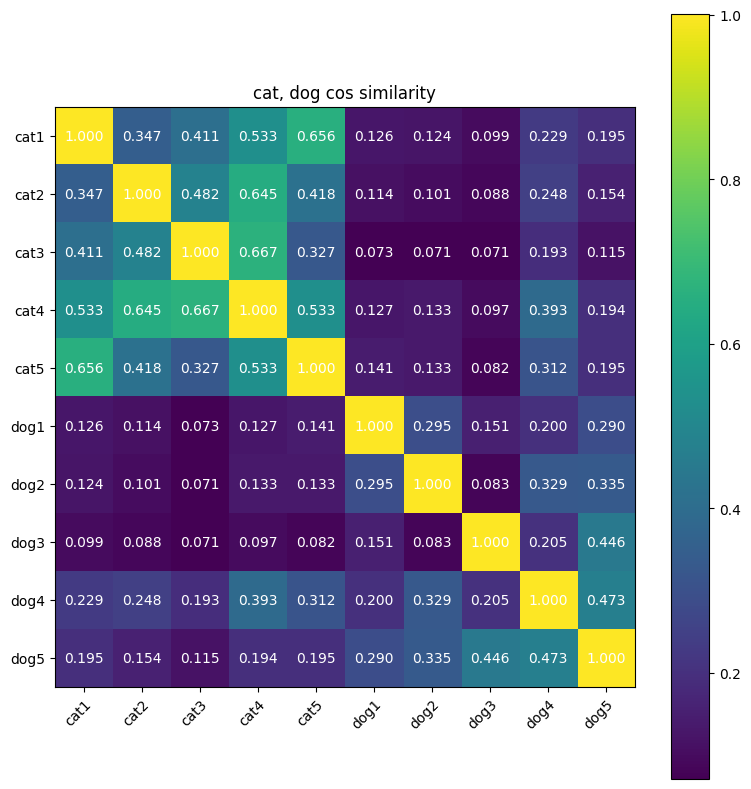

In [32]:
plt.figure(figsize=(8, 8))
plt.xticks(
    np.arange(len(names)), labels=names, rotation=45, rotation_mode="anchor", ha="right"
)
plt.yticks(np.arange(len(names)), labels=names)
plt.title("cat, dog cos similarity")

# 绘图
plt.imshow(cos_similarity)

# 添加文字
for i in range(len(names)):
    for j in range(len(names)):
        text = plt.text(
            j,
            i,
            "{:.3f}".format(cos_similarity[i, j]),
            ha="center",
            va="center",
            color="w",
        )

plt.colorbar()  # 右侧的条
plt.tight_layout()
plt.show()